In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [2]:
from core.analysis import load_episode_data
from utils.hierarchical_sparse_compressor import HierarchicalSparseCompressor
from configs.ssc import all_configs
import numpy as np
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import os
import pandas as pd
import collections

In [3]:
def plot_trajectories(df, column, discrete=True, cmap='magma', n_actions=5, n_intervals=11, n_epochs_per_interval=100, figsize=10,  max_length=100):
    breaks = [int(x) for x in np.linspace(0, len(df), n_intervals)]
    prev_end = 0
    vmin = np.min(np.min(df[column]))
    vmax = np.max(np.max(df[column]))
    for i, bound in enumerate(breaks[1:]):
        data = df[column][prev_end:prev_end+n_epochs_per_interval]
        padded = []
        for d in data:
            to_append = d + [np.nan] * (max_length - len(d))
            padded.append(d + [np.nan] * (max_length - len(d)))
        if discrete:
            cmap = cmap_discretize(cmap, n_actions)
        fig = plt.figure(figsize=(figsize,figsize/2))
        plot = plt.imshow(padded, cmap=cmap, vmin=vmin, vmax=vmax)
        plt.colorbar()  
        fig.suptitle('epoch {}:{}'.format(prev_end, prev_end+n_epochs_per_interval), fontsize=20)   
        prev_end = bound
        
def cmap_discretize(cmap, N):
    """Return a discrete colormap from the continuous colormap cmap.
    cmap: colormap instance, eg. cm.jet. 
         N: number of colors.     
     Example
     x = resize(arange(100), (5,100))
     djet = cmap_discretize(cm.jet, 5)
     imshow(x, cmap=djet)
     """
    if type(cmap) == str:
        cmap = plt.get_cmap(cmap)
    colors_i = np.concatenate((np.linspace(0, 1., N), (0.,0.,0.,0.)))
    colors_rgba = cmap(colors_i)
    indices = np.linspace(0, 1., N+1)
    cdict = {}
    for ki,key in enumerate(('red','green','blue')):
        cdict[key] = [(indices[i], colors_rgba[i-1,ki], colors_rgba[i,ki]) for i in np.arange(N+1)]
        # Return colormap object.
    return matplotlib.colors.LinearSegmentedColormap(cmap.name + "_%d"%N, cdict, 1024)

def convert_trajectories(trajectories_list, num_possible_actions, h_action_key):
    max_length = np.max([len(x) for x in trajectories_list])
    bin_actions = convert_to_binary(trajectories_list, num_possible_actions, h_action_key)
    max_length = np.max([x.shape[1] for x in bin_actions])
    matrix = data_to_matrix(bin_actions, num_possible_actions, max_length)
    return matrix

def flatten(x): 
    if isinstance(x, collections.Iterable): 
        return [a for i in x for a in flatten(i)] 
    else: 
        return [x] 
    
def uncompress_h_action(h_action, dic, n_primitives):
    primitive = False if np.any([x >= n_primitives for x in h_action]) else True
    while not primitive:
        primitive_sequence = []
        for x in h_action:
            if x < n_primitives:
                primitive_sequence.append(x)
            else: 
                primitive_sequence += dic[x]
        h_action = primitive_sequence
        primitive = False if np.any([x >= n_primitives for x in h_action]) else True
    return h_action

In [4]:
directory = '../experiments/__ssc_hanoi_2disks_seed4_2-to-3_from-ep10000_lr0.0005_3-to-4_from-ep45000_lr0.0005/'

In [5]:
dic = pd.read_pickle(directory+'action_dictionary.p')

In [18]:
len(df.state[0])

15158

In [7]:
df = load_episode_data(directory)

                                              action  \
0  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
1  [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, ...   
2  [3, 3, 3, 3, 3, 3, 3, 3, 6, 5, 0, 0, 0, 0, 0, ...   

                                       action_length  \
0  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   
1  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   
2  [1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, ...   

                                            env_data  episode  \
0  [[[0, 0, 0, 0, 1, 2, 3, 4], [0, 0, 0, 0, 0, 0,...      1.0   
1  [[[0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0,...      3.0   
2  [[[0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 1, 2,...      2.0   

                                             logprob  \
0  [-0.0003607923863455653, -0.000941719801630824...   
1  [-0.006333157420158386, -0.02925153076648712, ...   
2  [-0.04041002318263054, -0.07078202813863754, -...   

                                                mask  \
0  [1, 1

In [6]:
dic

{6: [3, 2],
 7: [5, 0],
 8: [6, 4],
 9: [1, 3],
 10: [1, 4],
 11: [9, 4],
 12: [0, 11],
 13: [0, 1],
 14: [8, 12],
 15: [7, 14],
 16: [6, 4],
 17: [0, 9],
 18: [0, 4],
 19: [5, 18],
 20: [16, 17],
 21: [16, 6],
 22: [0, 21],
 23: [4, 19]}

In [244]:
df['unpacked_action'] = [uncompress_h_action(x, dic, 6) for x in df.action]

In [245]:
df['episode_length'] = [np.sum(x) for x in df.action_length]

In [246]:
df['total_reward'] = [np.sum(flatten(x)) for x in df['reward']]

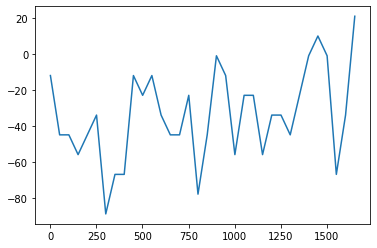

In [248]:
plt.plot(df.episode[:1700][::50], df.total_reward[:1700][::50])

In [231]:
np.sum(flatten(df['reward'][0]))

8.0

In [232]:
len(df['unpacked_action'][0])

93

In [233]:
df.action

0       [1, 10, 3, 2, 2, 0, 8, 10, 4, 8, 15, 11, 14, 9...
1                       [3, 14, 13, 14, 11, 3, 9, 10, 15]
2       [0, 2, 4, 0, 12, 3, 10, 14, 9, 5, 13, 10, 5, 1...
3       [8, 6, 13, 0, 13, 4, 15, 11, 0, 11, 1, 11, 9, ...
4       [3, 5, 9, 13, 6, 14, 1, 13, 14, 3, 0, 12, 2, 2...
                              ...                        
4895                       [8, 5, 3, 12, 2, 6, 5, 12, 14]
4896          [7, 1, 12, 2, 7, 15, 5, 14, 3, 7, 4, 0, 14]
4897                                  [10, 12, 5, 12, 14]
4898                                       [11, 7, 4, 14]
4899                            [14, 6, 11, 3, 5, 12, 14]
Name: action, Length: 4900, dtype: object

In [234]:
df.unpacked_action

0       [1, 1, 4, 3, 2, 2, 0, 3, 2, 4, 1, 4, 4, 3, 2, ...
1       [3, 3, 2, 4, 0, 1, 3, 4, 0, 1, 3, 2, 4, 0, 1, ...
2       [0, 2, 4, 0, 0, 1, 3, 4, 3, 1, 4, 3, 2, 4, 0, ...
3       [3, 2, 4, 3, 2, 0, 1, 0, 0, 1, 4, 5, 0, 3, 2, ...
4       [3, 5, 1, 3, 0, 1, 3, 2, 3, 2, 4, 0, 1, 3, 4, ...
                              ...                        
4895    [3, 2, 4, 5, 3, 0, 1, 3, 4, 2, 3, 2, 5, 0, 1, ...
4896    [5, 0, 1, 0, 1, 3, 4, 2, 5, 0, 5, 0, 3, 2, 4, ...
4897    [1, 4, 0, 1, 3, 4, 5, 0, 1, 3, 4, 3, 2, 4, 0, ...
4898              [1, 3, 4, 5, 0, 4, 3, 2, 4, 0, 1, 3, 4]
4899    [3, 2, 4, 0, 1, 3, 4, 3, 2, 1, 3, 4, 3, 5, 0, ...
Name: unpacked_action, Length: 4900, dtype: object

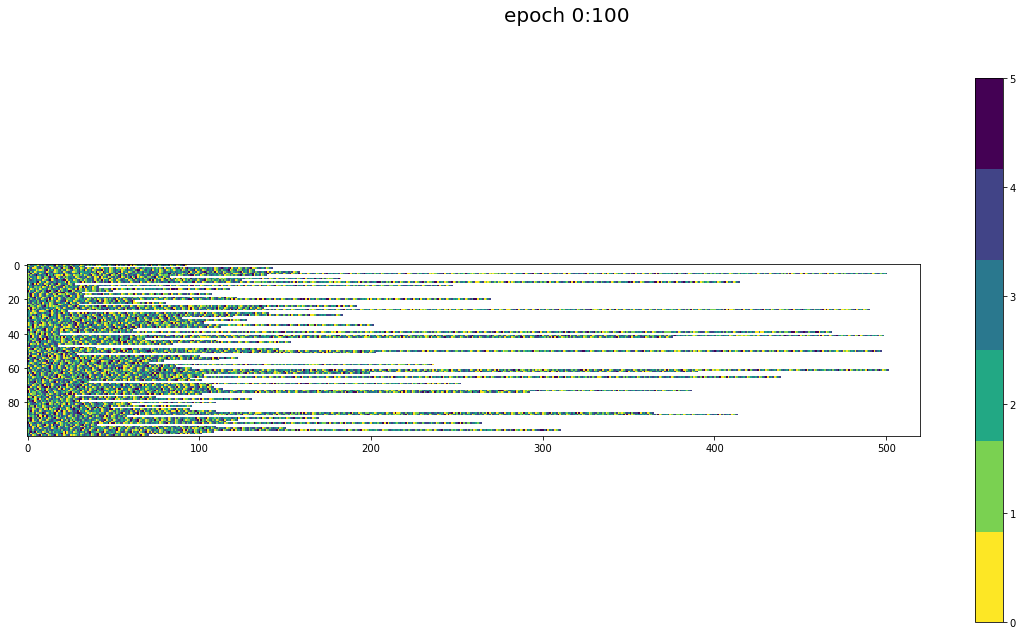

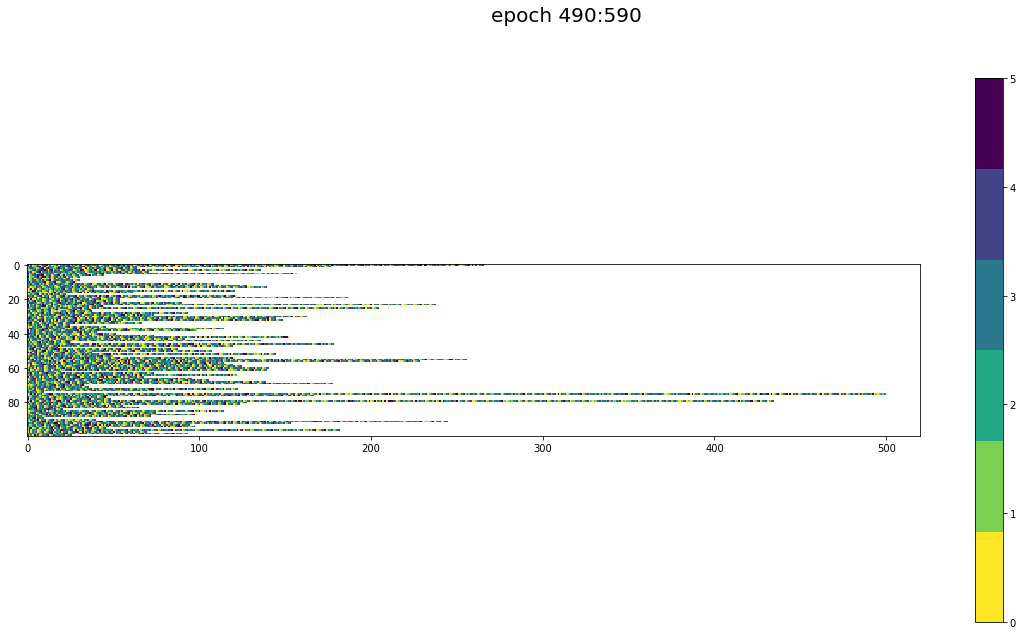

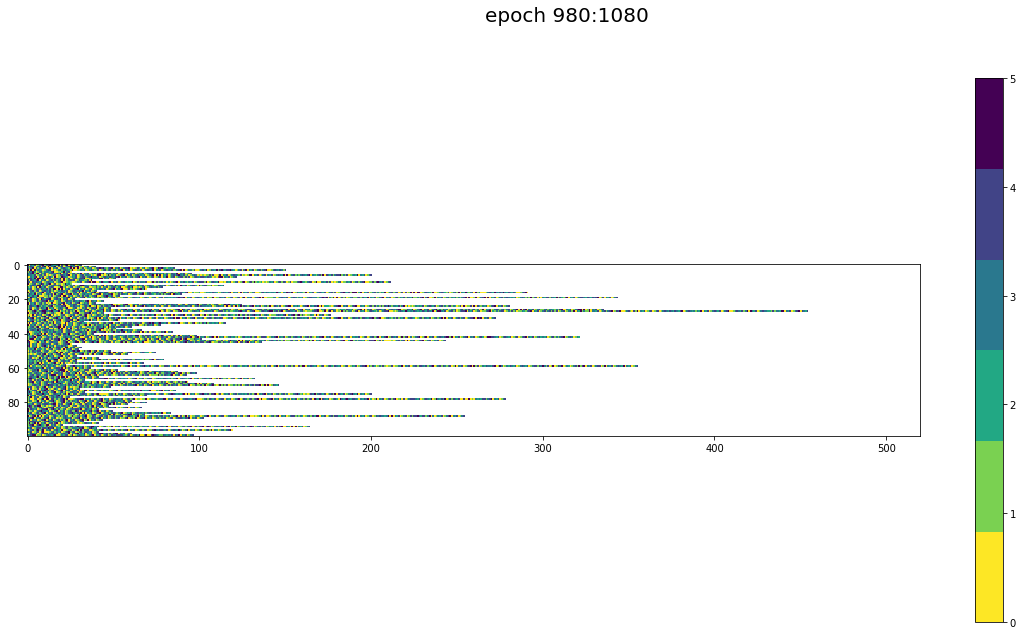

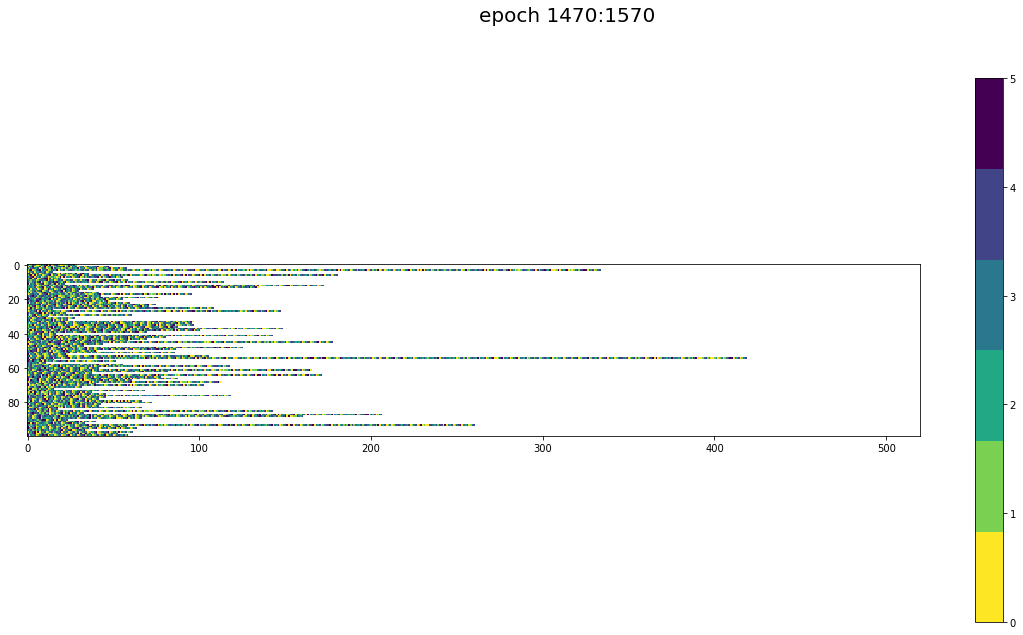

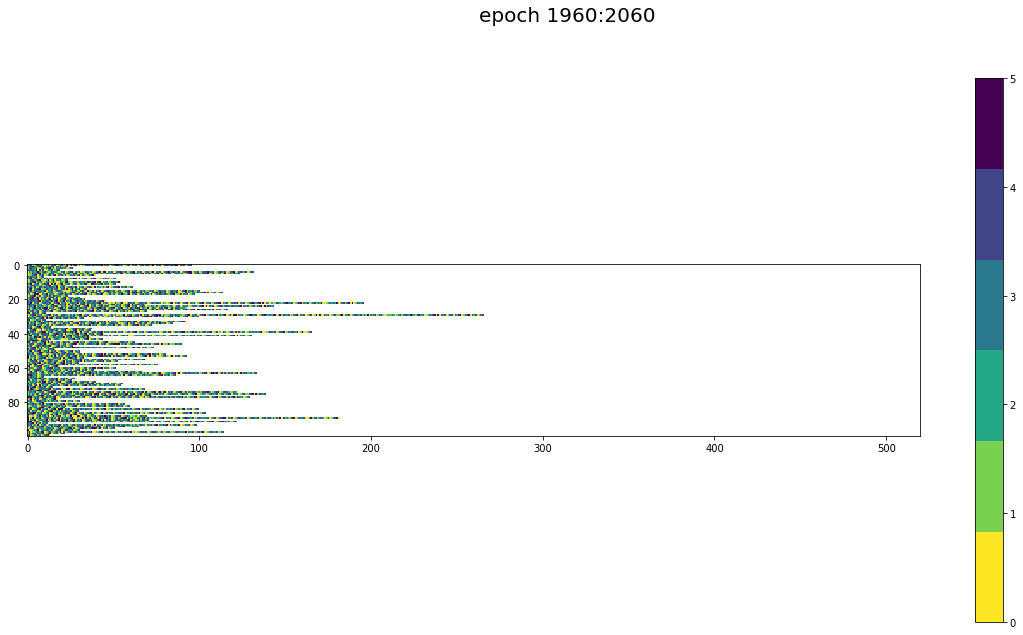

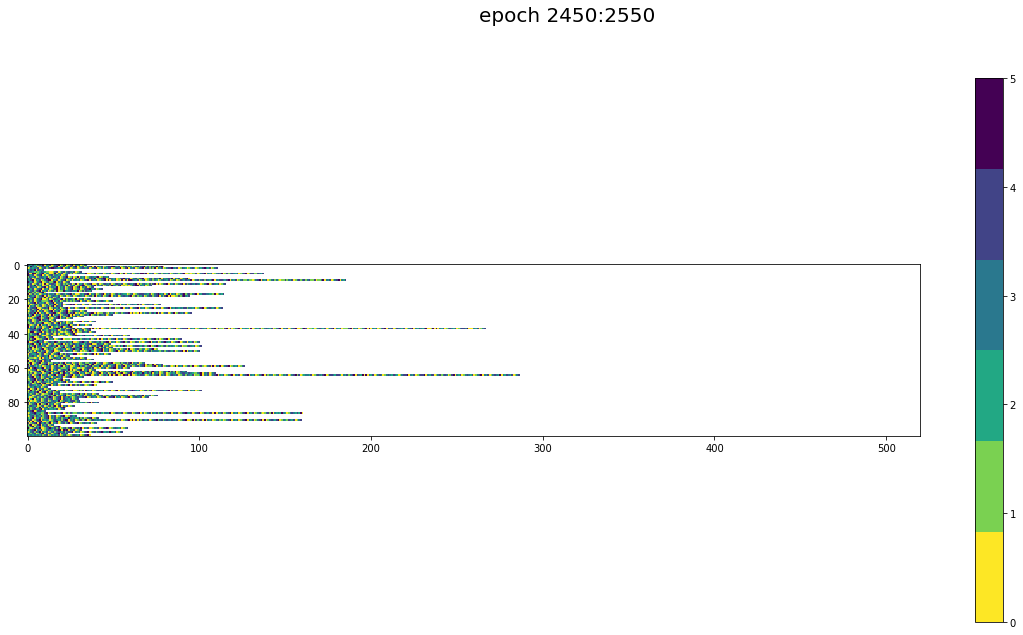

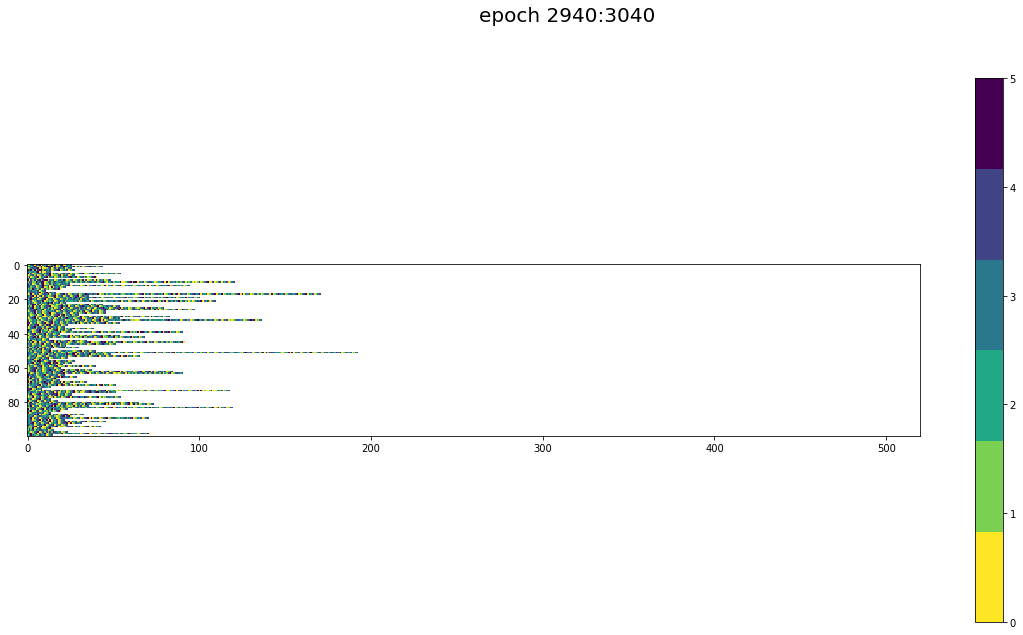

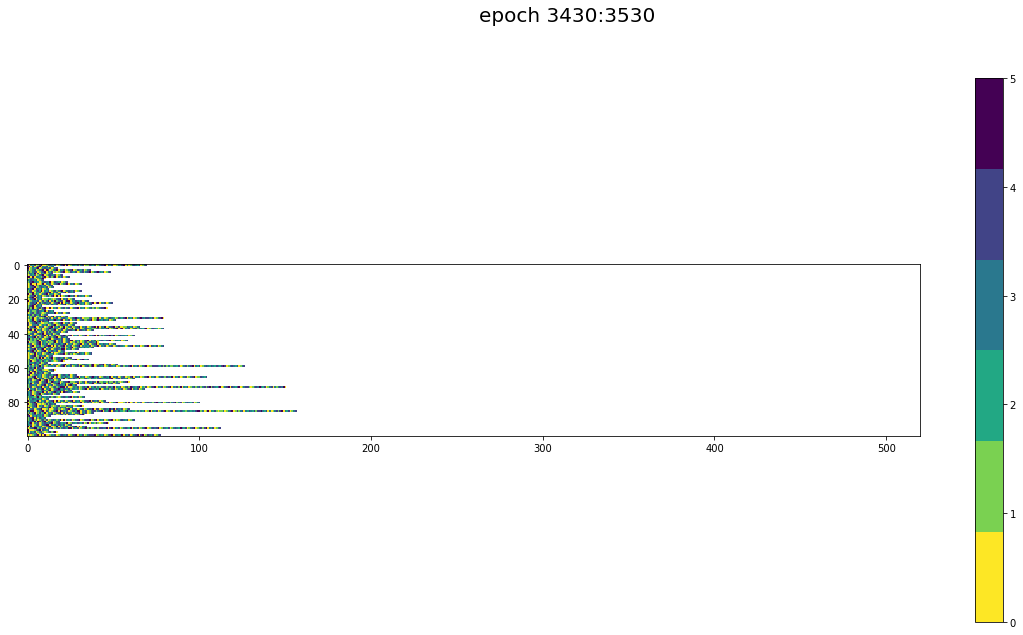

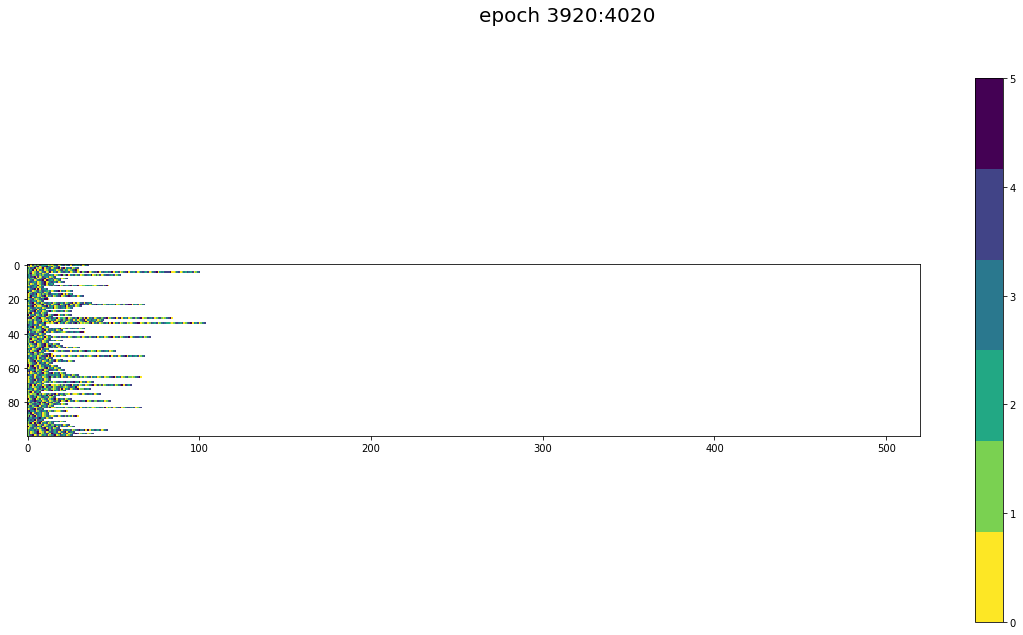

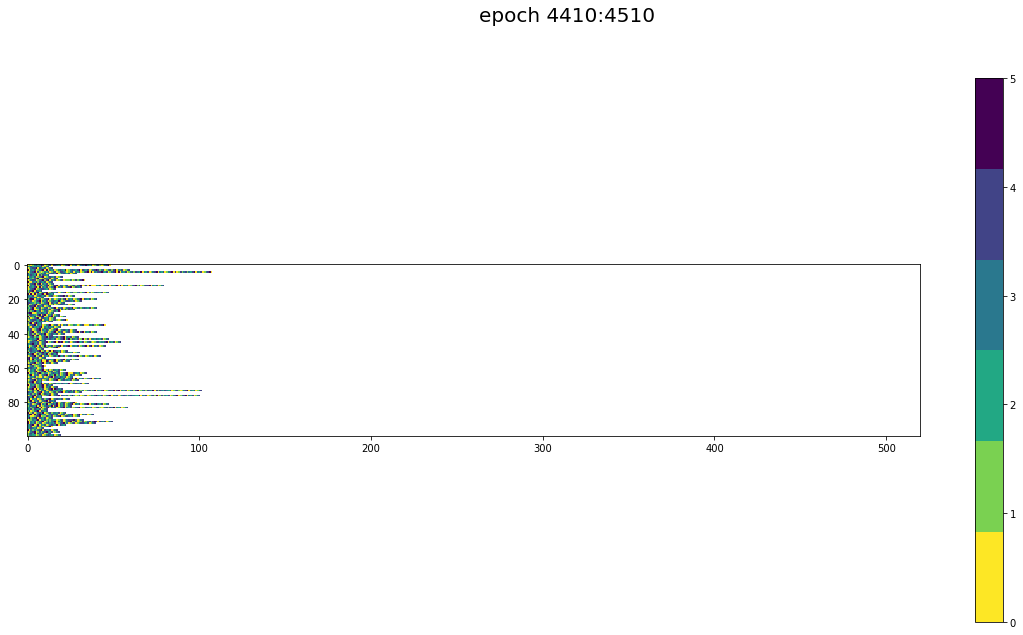

In [238]:
plot_trajectories(df, 'unpacked_action', n_actions=6, max_length=520, figsize=20, cmap='viridis_r')

In [3]:
config = all_configs['lightbot']

In [8]:
df['mean_reward'] = [np.sum(x) for x in df.reward]

In [17]:
len(df.action[0])

68

In [75]:
np.sum(df.action_length[15])

99

In [59]:
r = []
for x in df.reward[17]:
    if type(x)==float:
        r.append(x)
    else:
        r += x

In [60]:
np.sum(r)

-67.0

In [46]:
len(df)

18

In [77]:
df.env_data[0]

[OrderedDict([('coords', (4, 4)),
              ('height', 1),
              ('direction', 3),
              ('light_idx', -1),
              ('lights_on', array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]))]),
 OrderedDict([('coords', (4, 4)),
              ('height', 1),
              ('direction', 3),
              ('light_idx', -1),
              ('lights_on', array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]))]),
 OrderedDict([('coords', (4, 4)),
              ('height', 1),
              ('direction', 3),
              ('light_idx', -1),
              ('lights_on', array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]))]),
 OrderedDict([('coords', (4, 4)),
              ('height', 1),
              ('direction', 3),
              ('light_idx', -1),
              ('lights_on', array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]))]),
 OrderedDict([('coords', (4, 4)),
              ('height', 1),
              ('direction', 3),
              ('light_idx', -1),
              ('lights_on', array([0, 0, 0, 0, 0, 0, 0, 

In [10]:
config.algorithm.n_actions = 5
config.algorithm.count_criterion = None
config.algorithm.max_atoms = 20

In [11]:
hsc = HierarchicalSparseCompressor(config.algorithm)

In [12]:
data = list(df.action)

In [13]:
data = [x for x in data if len(x) < 60]

In [14]:
len(data)

2666

In [21]:
patches = []
for d in data:
    for i in range(len(d)-2):
        patches.append(tuple(d[i:i+2]))

In [24]:
patches.count((2,0))

14108

In [19]:
patches.count((0,1))

1241

n learning stages: 4
 training layer 0 


INFO:hdnet:Learning 41859 10-bit (nonzero) binary patterns, sparsity 0.1976...
INFO:hdnet:Chomping samples from model
INFO:hdnet:Raw: 10-bit, 27 patterns
INFO:hdnet:Chomping dynamics (from network learned on the samples) applied to samples
INFO:hdnet:Hopfield: 10-bit, 23 patterns


[5, 4, 0, 9, 8, 1, 2, 3, 10, 11]
[([0, 1], 18390), ([2, 0], 6084), ([0, 2], 5407), ([4, 2], 4640), ([0, 4], 4354), ([2, 2], 3970), ([2, 4], 2874), ([4, 0], 2323), ([2, 3], 2295), ([3, 0], 1888), ([1, 1], 1739), ([1, 0], 1378), ([3, 2], 933), ([1, 2], 636), ([2, 1], 466), ([3, 3], 214), ([4, 1], 166), ([3, 1], 92), ([1, 3], 85), ([1, 4], 27), ([4, 4], 20), ([4, 3], 10), ([3, 4], 9)]
[BatchCDL] Max value for lambda: 2.8895235761865363
[BatchCDL] CD iterations 0 / 10
[BatchCDL] lambda = 2.601e+00
[BatchCDL] sparsity: 8.038e-03
[BatchCDL] Objective (z) : 1.323e+05
[Update D]: 5 iterations
[BatchCDL] Resampled atom 0
[BatchCDL] Objective (d) : 1.311e+05
[BatchCDL] CD iterations 1 / 10
[BatchCDL] lambda = 2.601e+00
[BatchCDL] sparsity: 1.320e-02
[BatchCDL] Objective (z) : 1.280e+05
[Update D]: 3 iterations
[BatchCDL] Resampled atom 1
[BatchCDL] Objective (d) : 1.280e+05
[BatchCDL] CD iterations 2 / 10
[BatchCDL] lambda = 2.601e+00
[BatchCDL] sparsity: 1.595e-02
[BatchCDL] Objective (z) : 1.2

INFO:hdnet:Learning 35776 12-bit (nonzero) binary patterns, sparsity 0.1643...
INFO:hdnet:Chomping samples from model
INFO:hdnet:Raw: 12-bit, 36 patterns
INFO:hdnet:Chomping dynamics (from network learned on the samples) applied to samples
INFO:hdnet:Hopfield: 12-bit, 27 patterns


[0, 8, 9, 2, 10, 4, 3, 11, 5, 12]
[([0, 2], 21822), ([5, 4], 4162), ([4, 2], 4110), ([2, 4], 2874), ([2, 5], 2421), ([0, 5], 2329), ([4, 0], 2323), ([2, 3], 2295), ([5, 1], 1922), ([3, 0], 1888), ([1, 1], 1739), ([2, 2], 1549), ([1, 0], 1378), ([4, 5], 530), ([1, 5], 488), ([3, 5], 470), ([2, 1], 466), ([3, 2], 463), ([3, 3], 214), ([4, 1], 166), ([1, 2], 148), ([3, 1], 92), ([1, 3], 85), ([1, 4], 27), ([4, 4], 20), ([4, 3], 10), ([3, 4], 9)]
[BatchCDL] Max value for lambda: 2.725596468424543
[BatchCDL] CD iterations 0 / 10
[BatchCDL] lambda = 2.453e+00
[BatchCDL] sparsity: 3.522e-03
[BatchCDL] Objective (z) : 1.243e+05
[Update D]: 6 iterations
[BatchCDL] Resampled atom 0
[BatchCDL] Objective (d) : 1.241e+05
[BatchCDL] CD iterations 1 / 10
[BatchCDL] lambda = 2.453e+00
[BatchCDL] sparsity: 5.414e-03
[BatchCDL] Objective (z) : 1.215e+05
[Update D]: 1 iterations
[BatchCDL] Resampled atom 1
[BatchCDL] Objective (d) : 1.215e+05
[BatchCDL] CD iterations 2 / 10
[BatchCDL] lambda = 2.453e+00


INFO:hdnet:Learning 31665 14-bit (nonzero) binary patterns, sparsity 0.1406...
INFO:hdnet:Chomping samples from model
INFO:hdnet:Raw: 14-bit, 47 patterns
INFO:hdnet:Chomping dynamics (from network learned on the samples) applied to samples
INFO:hdnet:Hopfield: 14-bit, 36 patterns


[0, 8, 2, 3, 4, 5, 11, 9, 6, 7]
[([0, 2], 17974), ([5, 6], 4162), ([2, 4], 2327), ([4, 0], 2323), ([0, 5], 2288), ([5, 1], 1921), ([3, 0], 1888), ([6, 5], 1874), ([1, 1], 1739), ([1, 0], 1378), ([6, 3], 1359), ([2, 2], 993), ([2, 3], 936), ([6, 2], 556), ([2, 5], 547), ([4, 5], 530), ([2, 6], 526), ([1, 5], 488), ([3, 5], 470), ([3, 2], 463), ([6, 1], 300), ([3, 3], 214), ([2, 1], 166), ([4, 1], 166), ([1, 2], 148), ([3, 1], 92), ([1, 3], 85), ([1, 4], 26), ([6, 4], 17), ([4, 4], 17), ([4, 3], 10), ([3, 4], 6), ([6, 6], 4), ([3, 6], 3), ([4, 6], 3)]
[BatchCDL] Max value for lambda: 3.188669671059265
[BatchCDL] CD iterations 0 / 10
[BatchCDL] lambda = 2.870e+00
[BatchCDL] sparsity: 2.328e-03
[BatchCDL] Objective (z) : 1.418e+05
[Update D]: 4 iterations
[BatchCDL] Resampled atom 0
[BatchCDL] Objective (d) : 1.412e+05
[BatchCDL] CD iterations 1 / 10
[BatchCDL] lambda = 2.870e+00
[BatchCDL] sparsity: 6.320e-03
[BatchCDL] Objective (z) : 1.382e+05
[Update D]: 4 iterations
[BatchCDL] Resampl

INFO:hdnet:Learning 28391 16-bit (nonzero) binary patterns, sparsity 0.1228...
INFO:hdnet:Chomping samples from model
INFO:hdnet:Raw: 16-bit, 55 patterns
INFO:hdnet:Chomping dynamics (from network learned on the samples) applied to samples
INFO:hdnet:Hopfield: 16-bit, 44 patterns


[3, 7, 4, 8, 18, 5, 1, 9, 10, 17]
[([0, 5], 16263), ([5, 6], 4162), ([5, 1], 1920), ([6, 5], 1874), ([4, 7], 1851), ([1, 1], 1739), ([2, 4], 1377), ([6, 3], 1359), ([3, 0], 1041), ([7, 4], 950), ([7, 2], 902), ([1, 0], 891), ([3, 7], 847), ([7, 3], 700), ([6, 2], 556), ([7, 5], 539), ([4, 5], 530), ([2, 6], 509), ([1, 5], 488), ([1, 7], 487), ([4, 0], 472), ([3, 5], 470), ([3, 2], 463), ([6, 1], 300), ([2, 3], 236), ([3, 3], 214), ([4, 1], 166), ([7, 1], 162), ([1, 2], 148), ([3, 1], 92), ([2, 2], 91), ([1, 3], 85), ([1, 4], 26), ([7, 6], 17), ([6, 4], 17), ([4, 4], 17), ([4, 3], 10), ([2, 5], 8), ([3, 4], 6), ([6, 6], 4), ([2, 1], 4), ([3, 6], 3), ([4, 6], 3)]
[BatchCDL] Max value for lambda: 3.4579805517134794
[BatchCDL] CD iterations 0 / 10
[BatchCDL] lambda = 3.112e+00
[BatchCDL] sparsity: 2.629e-04
[BatchCDL] Objective (z) : 1.609e+05
[Update D]: 4 iterations
[BatchCDL] Resampled atom 0
[BatchCDL] Objective (d) : 1.609e+05
[BatchCDL] CD iterations 1 / 10
[BatchCDL] lambda = 3.112e

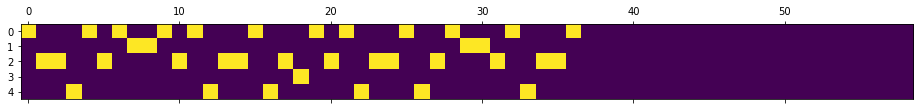

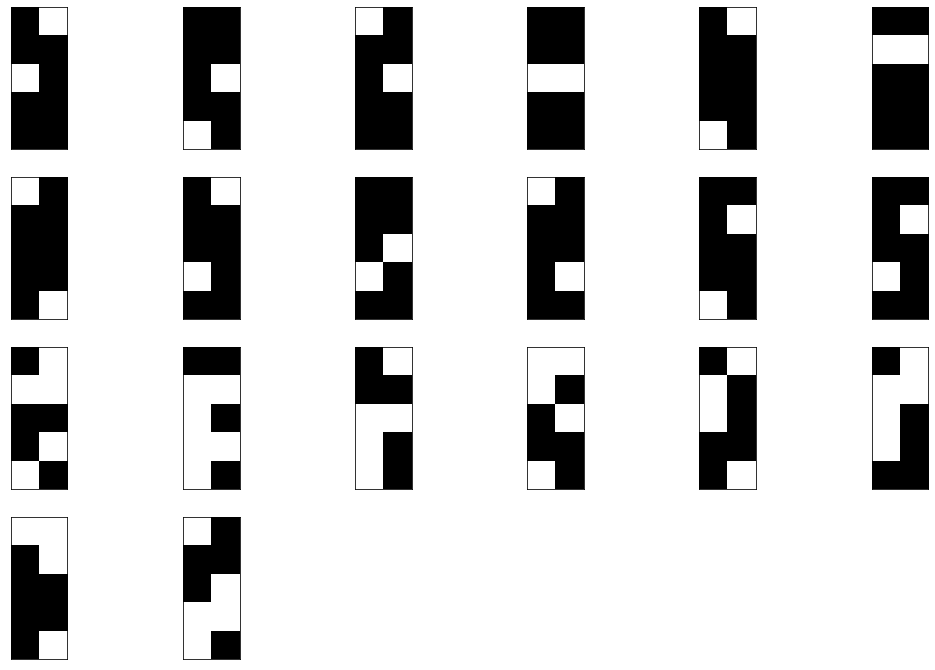

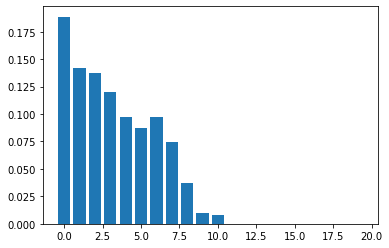

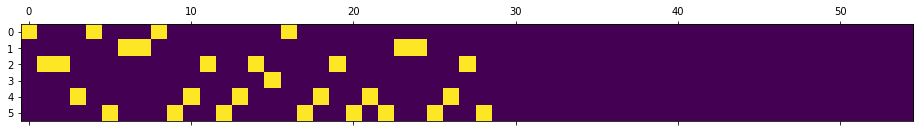

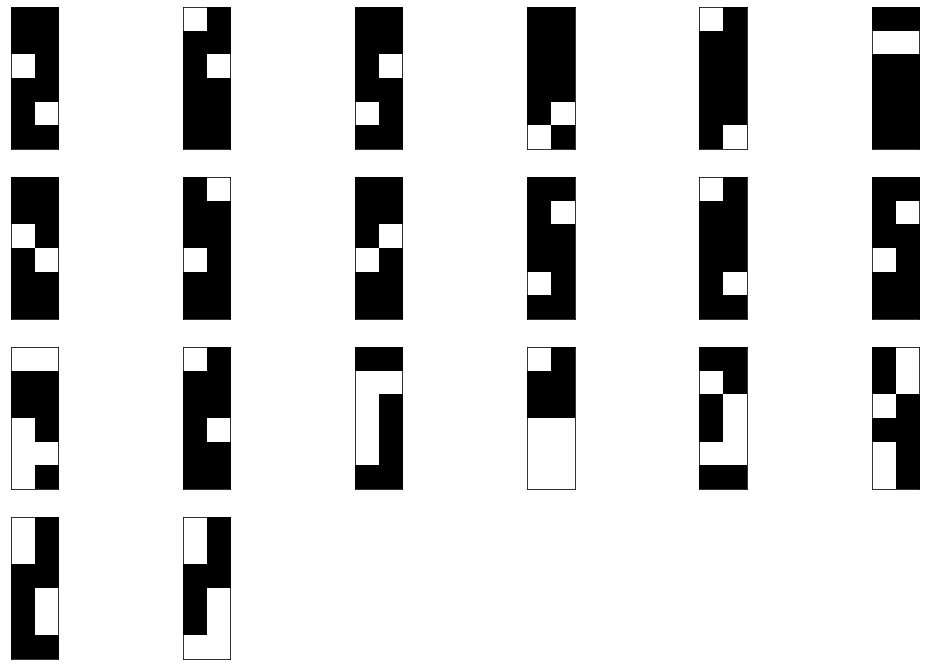

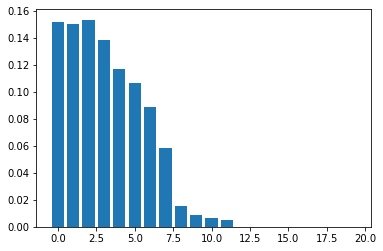

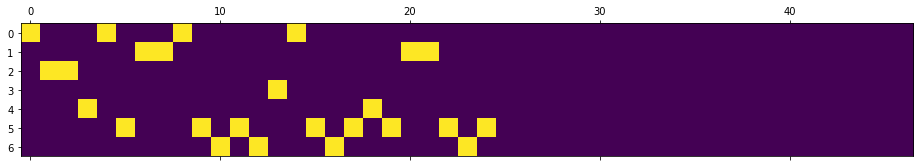

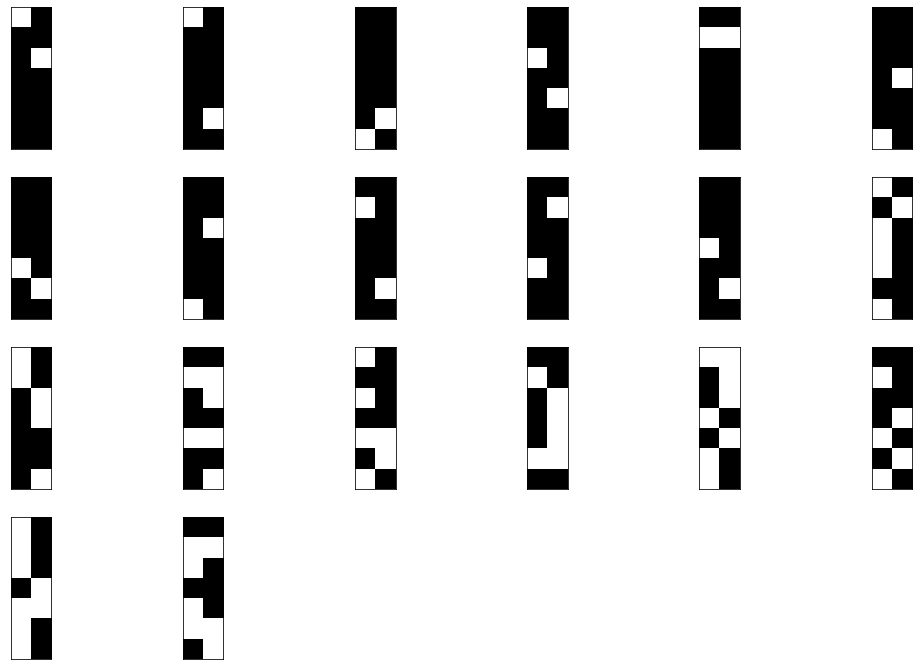

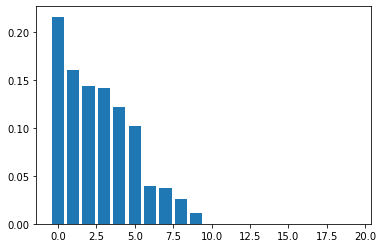

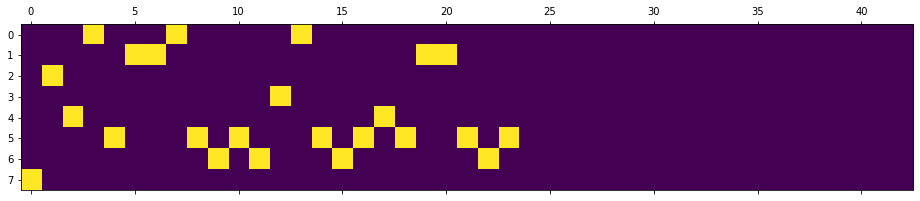

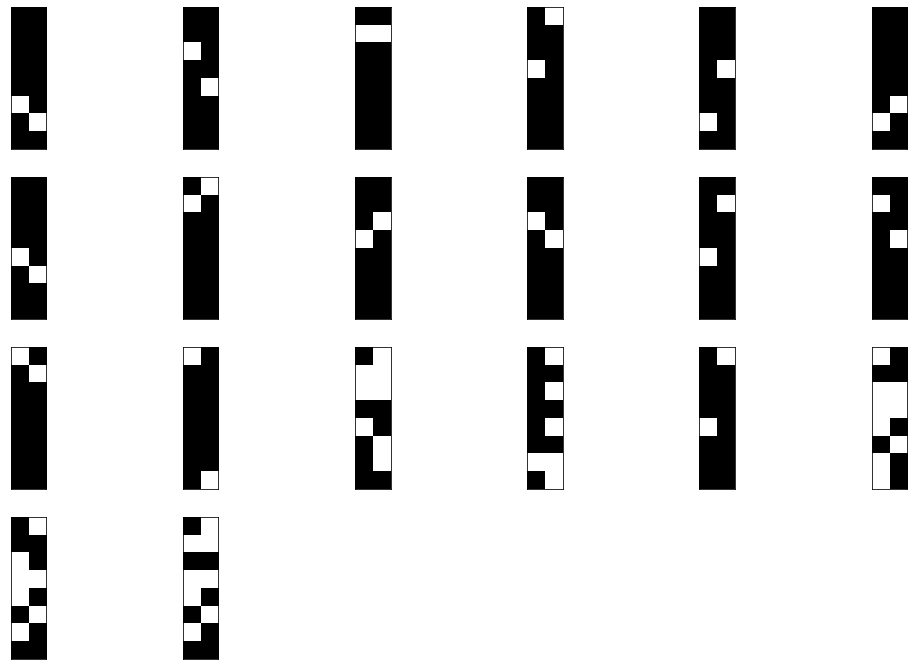

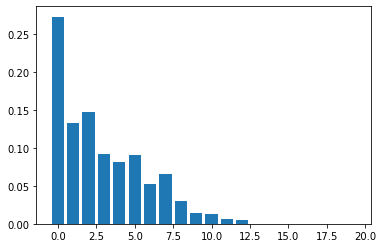

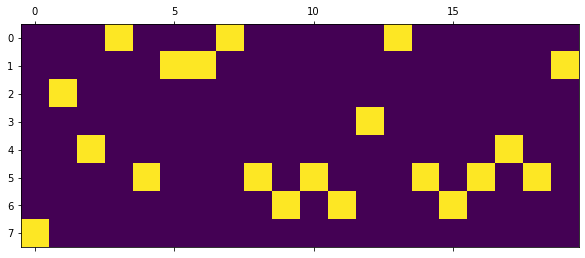

In [15]:
hsc.compress(data[:1000])

In [ ]:
hsc.data_history

In [32]:
40/9

4.444444444444445

In [35]:
np.max([len(x) for x in data])

500

In [36]:
500/9

55.55555555555556

In [41]:
len(data)

2666

In [43]:
hsc.trajectory_lengths

[37,
 39,
 40,
 42,
 44,
 37,
 41,
 44,
 42,
 37,
 38,
 40,
 40,
 42,
 38,
 38,
 40,
 41,
 41,
 41,
 45,
 42,
 41,
 38,
 41,
 40,
 44,
 38,
 42,
 43,
 45,
 42,
 39,
 54,
 41,
 42,
 42,
 43,
 43,
 40,
 43,
 40,
 38,
 41,
 41,
 39,
 44,
 41,
 46,
 42,
 44,
 43,
 42,
 42,
 41,
 41,
 45,
 39,
 39,
 38,
 37,
 42,
 40,
 42,
 41,
 41,
 39,
 41,
 38,
 40,
 39,
 38,
 42,
 46,
 37,
 39,
 49,
 43,
 52,
 44,
 42,
 43,
 43,
 39,
 39,
 39,
 40,
 42,
 42,
 39,
 40,
 53,
 42,
 41,
 41,
 40,
 41,
 42,
 40,
 49,
 41,
 41,
 38,
 41,
 39,
 40,
 43,
 42,
 41,
 39,
 39,
 39,
 38,
 41,
 42,
 41,
 39,
 40,
 39,
 42,
 45,
 41,
 42,
 38,
 41,
 55,
 41,
 41,
 39,
 44,
 40,
 42,
 40,
 43,
 42,
 40,
 39,
 39,
 39,
 48,
 39,
 41,
 39,
 45,
 40,
 43,
 43,
 43,
 39,
 45,
 39,
 41,
 43,
 40,
 43,
 42,
 38,
 39,
 43,
 40,
 43,
 41,
 42,
 42,
 43,
 43,
 41,
 42,
 42,
 38,
 41,
 43,
 42,
 41,
 42,
 43,
 41,
 41,
 37,
 43,
 42,
 53,
 46,
 41,
 40,
 42,
 41,
 39,
 40,
 41,
 41,
 42,
 43,
 40,
 44,
 40,
 41,
 56,
 52,
 57,
